In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import plotly.express as exp 
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
sb.set_style('darkgrid')

In [2]:
data = pd.read_csv('german_credit_risk.csv').drop(columns='id')
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [4]:
data.isnull().sum().sort_values(ascending = False)

Checking account    394
Saving accounts     183
Age                   0
Sex                   0
Job                   0
Housing               0
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [6]:
df = data.copy()
df['Job_cat'] = df['Job'].map({0: 'unskilled and non-resident',
                                1: 'unskilled and resident',
                                2: 'skilled',
                                3: 'highly skilled'})

In [7]:
# Replacing NA with string representation 'NA' in savings and current account
df.fillna('NA', inplace=True)

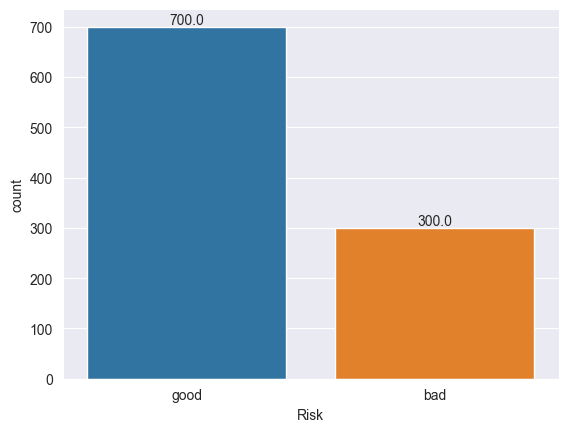

In [8]:
ax = sb.countplot(df, x = df.Risk)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

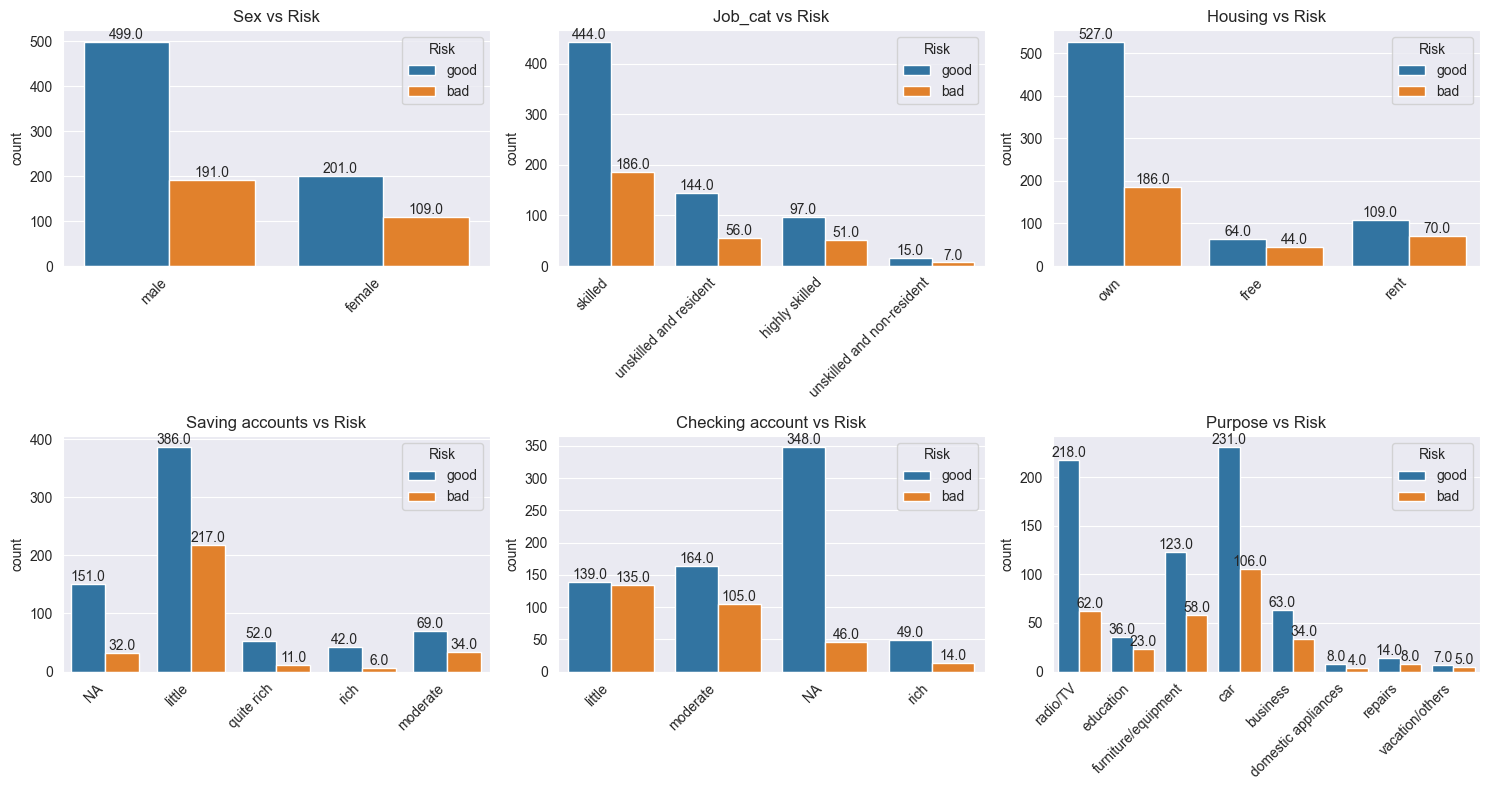

In [9]:
# Categorical Variables
categorical_cols = ['Sex', 'Job_cat', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Plot bar plots for categorical variables
rows = np.ceil(len(categorical_cols) / 3).astype(int)
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(15, 4*rows))
axes = axes.flatten()

for i in range(len(categorical_cols)):
    ax = sb.countplot(data=df, x=df[categorical_cols[i]], hue='Risk', ax=axes[i])
    ax.set_title(f'{categorical_cols[i]} vs Risk')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Tilt labels
    ax.set_xlabel('')

    for p in ax.patches:
        if p.get_height() != 0:  # Exclude annotations for bars with height 0
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [10]:
# radar plot for understanding the distribution of loan for each purpose
radio_tv = np.sum(data['Credit amount'].loc[data['Purpose'] == 'radio/TV'].values)
education = np.sum(data['Credit amount'].loc[data['Purpose'] == 'education'].values)
furniture = np.sum(data['Credit amount'].loc[data['Purpose'] == 'furniture/equipment'].values)
car = np.sum(data['Credit amount'].loc[data['Purpose'] == 'car'].values)
business = np.sum(data['Credit amount'].loc[data['Purpose'] == 'business'].values)
domestic_app = np.sum(data['Credit amount'].loc[data['Purpose'] == 'domestic appliances'].values)
repairs = np.sum(data['Credit amount'].loc[data['Purpose'] == 'repairs'].values)
vacation_others = np.sum(data['Credit amount'].loc[data['Purpose'] == 'vacation/others'].values)

In [11]:
data_purposes = pd.DataFrame(data={'Purpose': data["Purpose"].unique(), 
                                'Value':[radio_tv, education, furniture, car, business, domestic_app, repairs, vacation_others]})

# Create a tree map
fig = exp.treemap(data_purposes, path=['Purpose'], values='Value')

# Show the tree map
fig.show()

In [12]:
numeric_cols = ["Age", "Credit amount", "Duration"] 

In [13]:
# Plot histograms and box plots for numeric variables
for col in numeric_cols:
    fig = exp.histogram(df, x=col, marginal='box', title=f'Distribution of {col} by Risk')
    fig.show()


In [14]:
df['Age_cat'] = pd.cut(df['Age'], bins=[0, 24, 35, 50, float('inf')], 
                                   labels=['Young Adult', 'Adult', 'Middle-Aged', 'Senior'])

In [15]:
for col in numeric_cols[1:]:
    x = df[col].describe()
    df[col + '_cat'] = pd.cut(df[col], bins=[0, x['25%'], x['50%'], x['75%'], float('inf')], 
                                   labels=[f'<{x["25%"]}', f"{x['25%']}-{x['50%']}", f"{x['50%']}-{x['75%']}", f'>{x["75%"]}'])

In [16]:
for col in numeric_cols:
    conditional_prob = df.groupby(col + '_cat')['Risk'].value_counts(normalize=True).unstack().reset_index()
    fig = exp.bar(conditional_prob, x=col + '_cat', y=['good', 'bad'],
            barmode='group',
            title=f'Conditional Probability of Risk Given {col}')
    fig.show()

In [17]:
categorical_cols = ['Sex', 'Job_cat', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [18]:
for i, col in enumerate(categorical_cols, start=1):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "domain"}, {"type": "bar"}]],
        subplot_titles = ('Distribution', f'Risk given {col}')
    )
    cat_counts = df[col].value_counts()

    # Pie chart
    pie_chart = go.Pie(labels=cat_counts.index, values=cat_counts, name="Categories")
    fig.add_trace(pie_chart, row=1, col=1)
    fig.update_traces
    # Bar chart
    conditional_prob = df.groupby(col)['Risk'].value_counts(normalize=True).unstack().reset_index()
    bar_chart = go.Bar(x=conditional_prob[col], y=conditional_prob['good'], name="Good", marker_color='blue')
    bar_chart_bad = go.Bar(x=conditional_prob[col], y=conditional_prob['bad'], name="Bad", marker_color='red')
    
    fig.add_trace(bar_chart, row=1, col=2)
    fig.add_trace(bar_chart_bad, row=1, col=2)

    # Update layout
    fig.update_layout(
        height=400,
        # legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        title_text=f"Category Analysis - {col}",
        showlegend=True,
        barmode='group',  # Adjusted to display both bars
        bargap=0.2  # Adjusted to add a gap between bars
    )

    # Show the figure
    fig.show()

In [19]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Job_cat', 'Age_cat',
       'Credit amount_cat', 'Duration_cat'],
      dtype='object')

In [20]:
selected_columns = ['Age_cat', 'Sex', 'Saving accounts', 'Checking account', 'Credit amount_cat', 'Duration_cat', 'Purpose', 'Risk']

In [21]:
# Assuming 'df' is your DataFrame with selected columns
data = df[selected_columns]

mapping_dicts = {}
label_encoders = {}  # Create a dictionary to store label encoders for each column

# Iterate over columns and encode categorical columns
for column in data.columns:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])
    label_encoders[column] = label_encoder
    mapping_dicts[column] = dict([j, i] for i, j in enumerate(label_encoder.classes_))

# Features and target
X = data.drop(columns=['Risk'])
y = data['Risk']

In [22]:
mapping_dicts

{'Age_cat': {'Adult': 0, 'Middle-Aged': 1, 'Senior': 2, 'Young Adult': 3},
 'Sex': {'female': 0, 'male': 1},
 'Saving accounts': {'NA': 0,
  'little': 1,
  'moderate': 2,
  'quite rich': 3,
  'rich': 4},
 'Checking account': {'NA': 0, 'little': 1, 'moderate': 2, 'rich': 3},
 'Credit amount_cat': {'1365.5-2319.5': 0,
  '2319.5-3972.25': 1,
  '<1365.5': 2,
  '>3972.25': 3},
 'Duration_cat': {'12.0-18.0': 0, '18.0-24.0': 1, '<12.0': 2, '>24.0': 3},
 'Purpose': {'business': 0,
  'car': 1,
  'domestic appliances': 2,
  'education': 3,
  'furniture/equipment': 4,
  'radio/TV': 5,
  'repairs': 6,
  'vacation/others': 7},
 'Risk': {'bad': 0, 'good': 1}}

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Support Vector Classifier (SVC)
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_predictions)
print(f"SVC Accuracy: {svc_accuracy:.2f}")

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

SVC Accuracy: 0.72
Random Forest Accuracy: 0.73
Decision Tree Accuracy: 0.65
XGBoost Accuracy: 0.74


In [24]:
mapping_dicts

{'Age_cat': {'Adult': 0, 'Middle-Aged': 1, 'Senior': 2, 'Young Adult': 3},
 'Sex': {'female': 0, 'male': 1},
 'Saving accounts': {'NA': 0,
  'little': 1,
  'moderate': 2,
  'quite rich': 3,
  'rich': 4},
 'Checking account': {'NA': 0, 'little': 1, 'moderate': 2, 'rich': 3},
 'Credit amount_cat': {'1365.5-2319.5': 0,
  '2319.5-3972.25': 1,
  '<1365.5': 2,
  '>3972.25': 3},
 'Duration_cat': {'12.0-18.0': 0, '18.0-24.0': 1, '<12.0': 2, '>24.0': 3},
 'Purpose': {'business': 0,
  'car': 1,
  'domestic appliances': 2,
  'education': 3,
  'furniture/equipment': 4,
  'radio/TV': 5,
  'repairs': 6,
  'vacation/others': 7},
 'Risk': {'bad': 0, 'good': 1}}

In [28]:
# functions to get user input and get the purposes for which the user can be given loan
def input_data(mapping_dicts):
    user_data = {}
    for category, values in mapping_dicts.items():
        if category not in ['Purpose', 'Risk']:
            print(f"Choose {category}: {values.keys()}")
            user_input = input(f"Enter your choice for {category}: ").strip()
            user_data[category] = values.get(user_input)


    user_data_list = []

    for purpose in range(8):
        user_data_copy = user_data.copy()
        user_data_copy['Purpose'] = purpose
        user_data_list.append(user_data_copy)

    user_df = pd.DataFrame(user_data_list)
    return user_df

def loan_for_purpose(user_df, mapping_dicts, model):
    print(f'loan can be given for the below purposes with correspondind probability: ')
    prob = model.predict_proba(user_df)
    pred = xgb_model.predict(user_df)
    idx = np.where(pred==1)[0]
    for i, j in mapping_dicts['Purpose'].items():
        if j in idx:
            print(f'{i}\t{prob[j][1]:0.2f}')

In [29]:
user_df = input_data(mapping_dicts)

Choose Age_cat: dict_keys(['Adult', 'Middle-Aged', 'Senior', 'Young Adult'])
Choose Sex: dict_keys(['female', 'male'])
Choose Saving accounts: dict_keys(['NA', 'little', 'moderate', 'quite rich', 'rich'])
Choose Checking account: dict_keys(['NA', 'little', 'moderate', 'rich'])
Choose Credit amount_cat: dict_keys(['1365.5-2319.5', '2319.5-3972.25', '<1365.5', '>3972.25'])
Choose Duration_cat: dict_keys(['12.0-18.0', '18.0-24.0', '<12.0', '>24.0'])


In [47]:
loan_for_purpose(user_df, mapping_dicts, xgb_model)

loan can be given for the below purposes with correspondind probability: 
business	0.79
furniture/equipment	0.92
radio/TV	0.74
